Goal: interpret the model in a white-box fashion, looking inside the model at the learned filters and analyzing saliency maps for what positions and nucleotides matter most towards functional characteristics.

In [1]:
# import statements 

import os
#disable CUDA

import platform
import random
import shutil
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.metrics
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
from tqdm import tqdm_notebook as tqdm
import keras
%matplotlib inline
import math
import itertools

# some visualization imports
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations
import logomaker as lm

# various imports for the keras model
from keras.layers.core import Permute
from keras import backend as K
from keras.engine.topology import Layer
import keras as keras
#from keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import TensorBoard
from keras import metrics as metrics
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Conv1D, Concatenate
from keras.optimizers import SGD
from keras.regularizers import l2

# evaluate performance w/ on and off regression separately 
from scipy.stats import pearsonr, spearmanr 

# imports for the grid search and kfold CV
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

# data one-hot encoding imports
from pysster.One_Hot_Encoder import One_Hot_Encoder
from sklearn import preprocessing
from keras.utils import to_categorical

import matplotlib
import matplotlib.font_manager as fm
fpath = '/Library/Fonts/Myriad-Pro_31655.ttf'
prop = fm.FontProperties(fname=fpath)
fname = os.path.split(fpath)[1]
axis_font = {'fontname':fname, 'fontproperties':prop}

Using TensorFlow backend.


# Part 1: Load in data. Filter and sample to avoid bias from expiremental errors. 

In [2]:
data_dir = '../../data/'
file_name = 'newQC_toehold_data.csv'
data_df = pd.read_csv(data_dir + file_name,sep=',')
data_df.head(3)

,off_id,on_id,source_sequence,sequence_id,pre_seq,promoter,trigger,loop1,switch,loop2,...,stem2,linker,post_linker,on_value,off_value,onoff_value,on_qc,off_qc,onoff_qc,switch_sequence
0,AACCAAACACACAAACGCACAAAAAAAAAAAAAAAAAATGGAAAAC...,AACTGTTTTCCATTTTTTTTTTTTTTTTTTAACCAAACACACAAAC...,smallpox,smallpox_tile_2626,CTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGG,AACTGTTTTCCATTTTTTTTTTTTTTTTTT,AACCAAACACACAAACGCAC,AAAAAAAAAAAAAAAAAATGGAAAACAGTT,AACAGAGGAGA,...,CCATTTTTT,AACCTGGCGGCAGCGCAAAAGATGCG,TAAAGGAGAA,NaN,0.333333,NaN,NaN,NaN,NaN,AAAAAAAAAAAAAAAAAATGGAAAACAGTTAACAGAGGAGAAACTG...
1,AACCAAACACACAAACGCACAAAAAAAAAAAAATGGAAAACAGTTA...,TTAGTAACTGTTTTCCATTTTTTTTTTTTTAACCAAACACACAAAC...,smallpox,smallpox_tile_2625,CTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGG,TTAGTAACTGTTTTCCATTTTTTTTTTTTT,AACCAAACACACAAACGCAC,AAAAAAAAAAAAATGGAAAACAGTTACTAA,AACAGAGGAGA,...,GTTTTCCAT,AACCTGGCGGCAGCGCAAAAGATGCG,TAAAGGAGAA,NaN,NaN,NaN,NaN,NaN,NaN,AAAAAAAAAAAAATGGAAAACAGTTACTAAAACAGAGGAGATTAGT...
2,AACCAAACACACAAACGCACAAAAAAAAATTACTACTATTGTTAAT...,CTAAATTAACAATAGTAGTAATTTTTTTTTAACCAAACACACAAAC...,smallpox,smallpox_tile_4951,CTCTGGGCTAACTGTCGCGC,TAATACGACTCACTATAGGG,CTAAATTAACAATAGTAGTAATTTTTTTTT,AACCAAACACACAAACGCAC,AAAAAAAAATTACTACTATTGTTAATTTAG,AACAGAGGAGA,...,CAATAGTAG,AACCTGGCGGCAGCGCAAAAGATGCG,TAAAGGAGAA,0.068295,0.000000,0.068295,2.0,1.1,1.1,AAAAAAAAATTACTACTATTGTTAATTTAGAACAGAGGAGACTAAA...


In [3]:
qc_cutoff=1.1
data_df = data_df[data_df['on_qc'] >= qc_cutoff].reset_index()
data_df = data_df[data_df['off_qc'] >= qc_cutoff].reset_index()
toehold_seqs = data_df['switch_sequence']
seq_len = len(toehold_seqs[0])
print('Number of remaining sequences: ', len(data_df))

Number of remaining sequences:  91534


Now downsample data to avoid bias.

# Part 2. Transform Data. One-hot encode sequences and extact target on and off values.

In [4]:
alph_letters = sorted('ATCG')
alph = list(alph_letters)

# one-hot encode
one = One_Hot_Encoder(alph_letters)
def _get_one_hot_encoding(seq):
    one_hot_seq = one.encode(seq)                         
    return one_hot_seq

# now convert the data into one_hot_encoding 
input_col_name = 'switch_sequence'
X = np.stack([_get_one_hot_encoding(s) for s in toehold_seqs]).astype(np.float32)

# reformat for CNN if needed
print('input shape: ', X.shape)
alph_len = len(alph)
seq_len = len(data_df[input_col_name][0])
X = X.reshape(X.shape[0], seq_len, alph_len).astype('float32')
print('modified shape: ', X.shape)

y_on = np.array(data_df['on_value'].astype(np.float32))
y_off = np.array(data_df['off_value'].astype(np.float32))

# on and off combine
y = np.transpose(np.array([y_on,y_off,]))
print('target shape: ', y.shape)

input shape:  (91534, 59, 4)
modified shape:  (91534, 59, 4)
target shape:  (91534, 2)


# Part 3. Load in final model. 

In [5]:
from tensorflow.keras.models import load_model

output_dir = 'trained_model/'
final_model_path = output_dir + 'final_trained_model.h5'
final_weights_path = output_dir + 'final_trained_model_weights.h5'
model = load_model(final_model_path)
model.load_weights(final_weights_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [6]:
# visually check architecture
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 59, 4)        0                                            
__________________________________________________________________________________________________
conv_0 (Conv1D)                 (None, 59, 10)       210         input_2[0][0]                    
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 59, 5)        155         conv_0[0][0]                     
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 295)          0           conv_1[0][0]                     
__________________________________________________________________________________________________
dropout_4 

# Part 4. Generate saliency maps from a subset of possible toehold inputs. 

In [7]:
# look at saliency map for positive vs. negative classes
# modified code from keras-vis package github page 
# https://github.com/raghakot/keras-vis/blob/master/examples/mnist/attention.ipynb

from keras.models import load_model
final_model_path = output_dir + 'final_trained_model.h5'
final_weights_path = output_dir + 'final_trained_model_weights.h5'
model = load_model(final_model_path)
model.load_weights(final_weights_path)

# layer idx = what layer to maximize/minimize (i.e. output node)
# seed_input = the one-hot encoded sequence whose path thru the model we are tracing 
# filter_indices = what layer are we computing saliency w/ r.t. (i.e. input layer)

def viz_saliency_bar(model, seed_input, layer_idx=-2, filter_indices=0, grad_modifier=None, plotting = True):
    # maximize on prediction or minimize off prediction  
    grads = visualize_saliency(model, layer_idx=layer_idx, filter_indices=filter_indices, seed_input=seed_input,
                              grad_modifier=grad_modifier)
    # diff colors in plot represent the saliency of specific positions 
    if plotting:
        plt.rcParams["figure.figsize"] = 5,1

        x = list(range(0,seq_len))
        y = grads

        fig, ax = plt.subplots(ncols=1, sharex=True)

        extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
        ax.imshow(y[np.newaxis,:], cmap="jet", aspect="auto", extent=extent)
        ax.set_yticks([])
        ax.set_xlim(extent[0], extent[1])

        plt.tight_layout()
        plt.show()
    return grads

In [8]:
# Compute separately for on and off 
# NOTE: This takes a long time!

# ON 
num_show = 200 # len(indices)
grads = [] 
# randomly draw samples (w/o replacement)
rand_indices = np.random.choice(range(len(X)), num_show, replace=False)
for idx in rand_indices:
    grad = viz_saliency_bar(model, X[idx],plotting=False, layer_idx=-2, grad_modifier=None, filter_indices=0)
    grads.append(grad)

In [9]:
# look at average saliency based on original nucleotide
grads_over_letters_on = {c: np.zeros(seq_len) for c in alph}
counts_per_positon_on = {c: np.zeros(seq_len) for c in alph}

def ohot_to_seq(onehot_seq): 
    # return from one hot seq back to original toehold
    # get original letter based on index of the 1 
    seq = ''.join([alph[np.where(onehot_seq[idx] == 1)[0][0]] for idx in range(len(onehot_seq))])
    return seq 

for sample_idx,idx in enumerate(rand_indices): 
    onehot_toehold = X[idx]
    orig_toehold = ohot_to_seq(onehot_toehold)
    for position, nt in enumerate(orig_toehold): 
        grad_at_pos = grads[sample_idx][position]
        grads_over_letters_on[nt][position] += grad_at_pos
        counts_per_positon_on[nt][position] += 1 
        

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Text(0.5, 1.0, 'Maximize On Value')

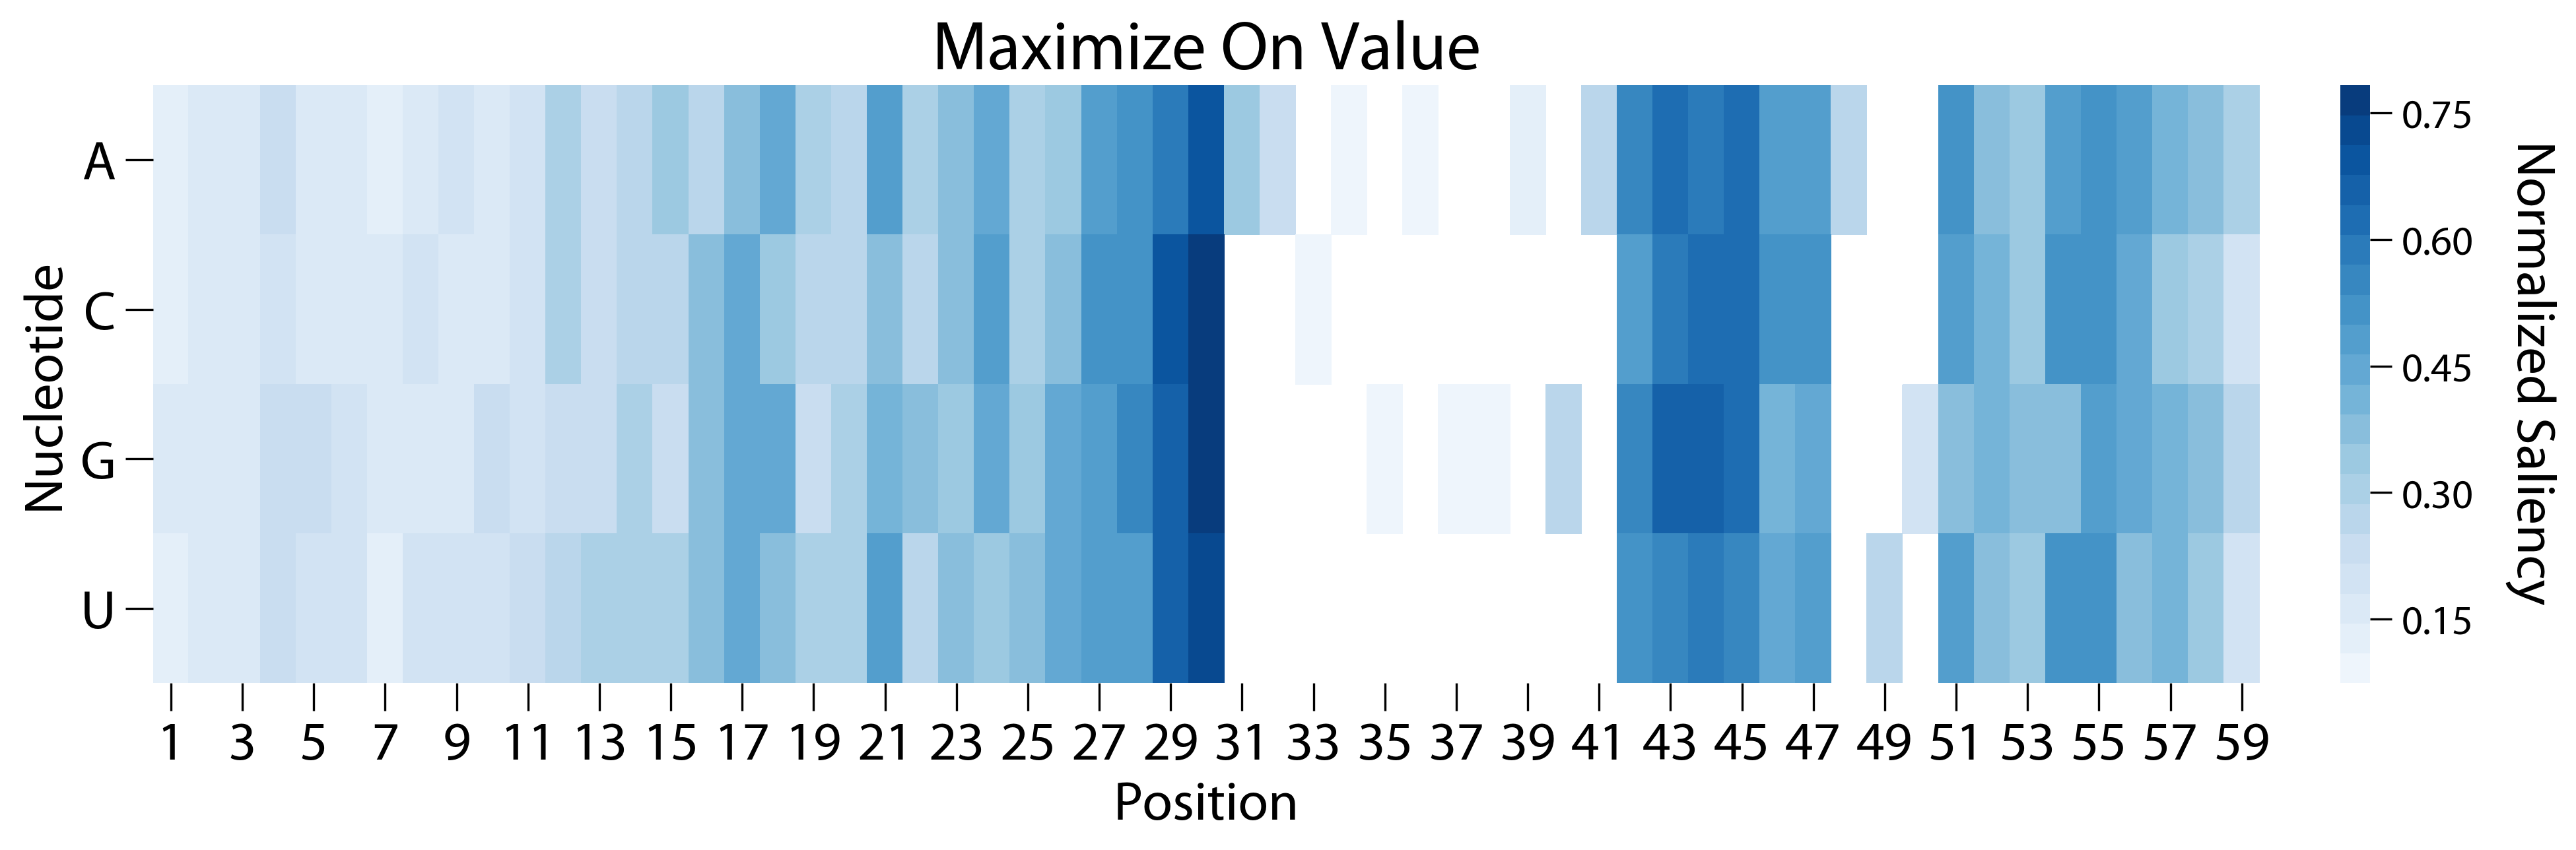

In [10]:
# Normalized by number of times a nt appeared at each position 
fig, ax = plt.subplots(figsize = (15,4), dpi = 300)
plt.rcParams["figure.dpi"] = 300

cmap = sns.color_palette("Blues", n_colors = 20)


g = sns.heatmap([grads_over_letters_on[letter]/counts_per_positon_on[letter] for letter in alph], 
                cmap=cmap,  cbar_kws={"orientation": "vertical", "pad": 0.035, "fraction": 0.05})

ax.tick_params(length = 10)
plt.xticks(np.arange(0.5, 60, 2), np.arange(1, 61, 2), fontsize = 15, rotation = 0)

rna_alph = ['A', 'C', 'G', 'U']
g.set_yticklabels(rna_alph, **axis_font, fontsize = 20, rotation = 0)
g.set_xticklabels(g.get_xticklabels(), **axis_font, fontsize = 20)
plt.xlabel('Position', **axis_font, fontsize = 20)
plt.ylabel('Nucleotide', **axis_font, fontsize = 20)

cbar = ax.collections[0].colorbar
cbar.set_label("Normalized Saliency  ", rotation = 270, **axis_font, fontsize = 20)
ax.collections[0].colorbar.ax.set_yticklabels(ax.collections[0].colorbar.ax.get_yticklabels(), **axis_font)
cbar.ax.get_yaxis().labelpad = 30
cbar_ax = fig.axes[-1]
cbar_ax.tick_params(length = 8, labelsize=15)

plt.title('Maximize On Value', **axis_font, fontsize = 25)

In [11]:
# repeat for OFF 

num_show = 200 # len(indices)
grads_off = [] 
# randomly draw samples (w/o replacement)
rand_indices_off = np.random.choice(range(len(X)), num_show, replace=False)
for idx in rand_indices_off:
    grad = viz_saliency_bar(model, X[idx],plotting=False,layer_idx=-1, grad_modifier='negate', filter_indices=0)
    grads_off.append(grad)

In [12]:
# look at average saliency based on original nucleotide
grads_over_letters_off = {c: np.zeros(seq_len) for c in alph}
counts_per_positon_off = {c: np.zeros(seq_len) for c in alph}

for sample_idx,idx in enumerate(rand_indices_off): 
    onehot_toehold = X[idx]
    orig_toehold = ohot_to_seq(onehot_toehold)
    for position, nt in enumerate(orig_toehold): 
        grad_at_pos = grads_off[sample_idx][position]
        grads_over_letters_off[nt][position] += grad_at_pos
        counts_per_positon_off[nt][position] += 1 
        

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Text(0.5, 1.0, 'Minimize Off Value')

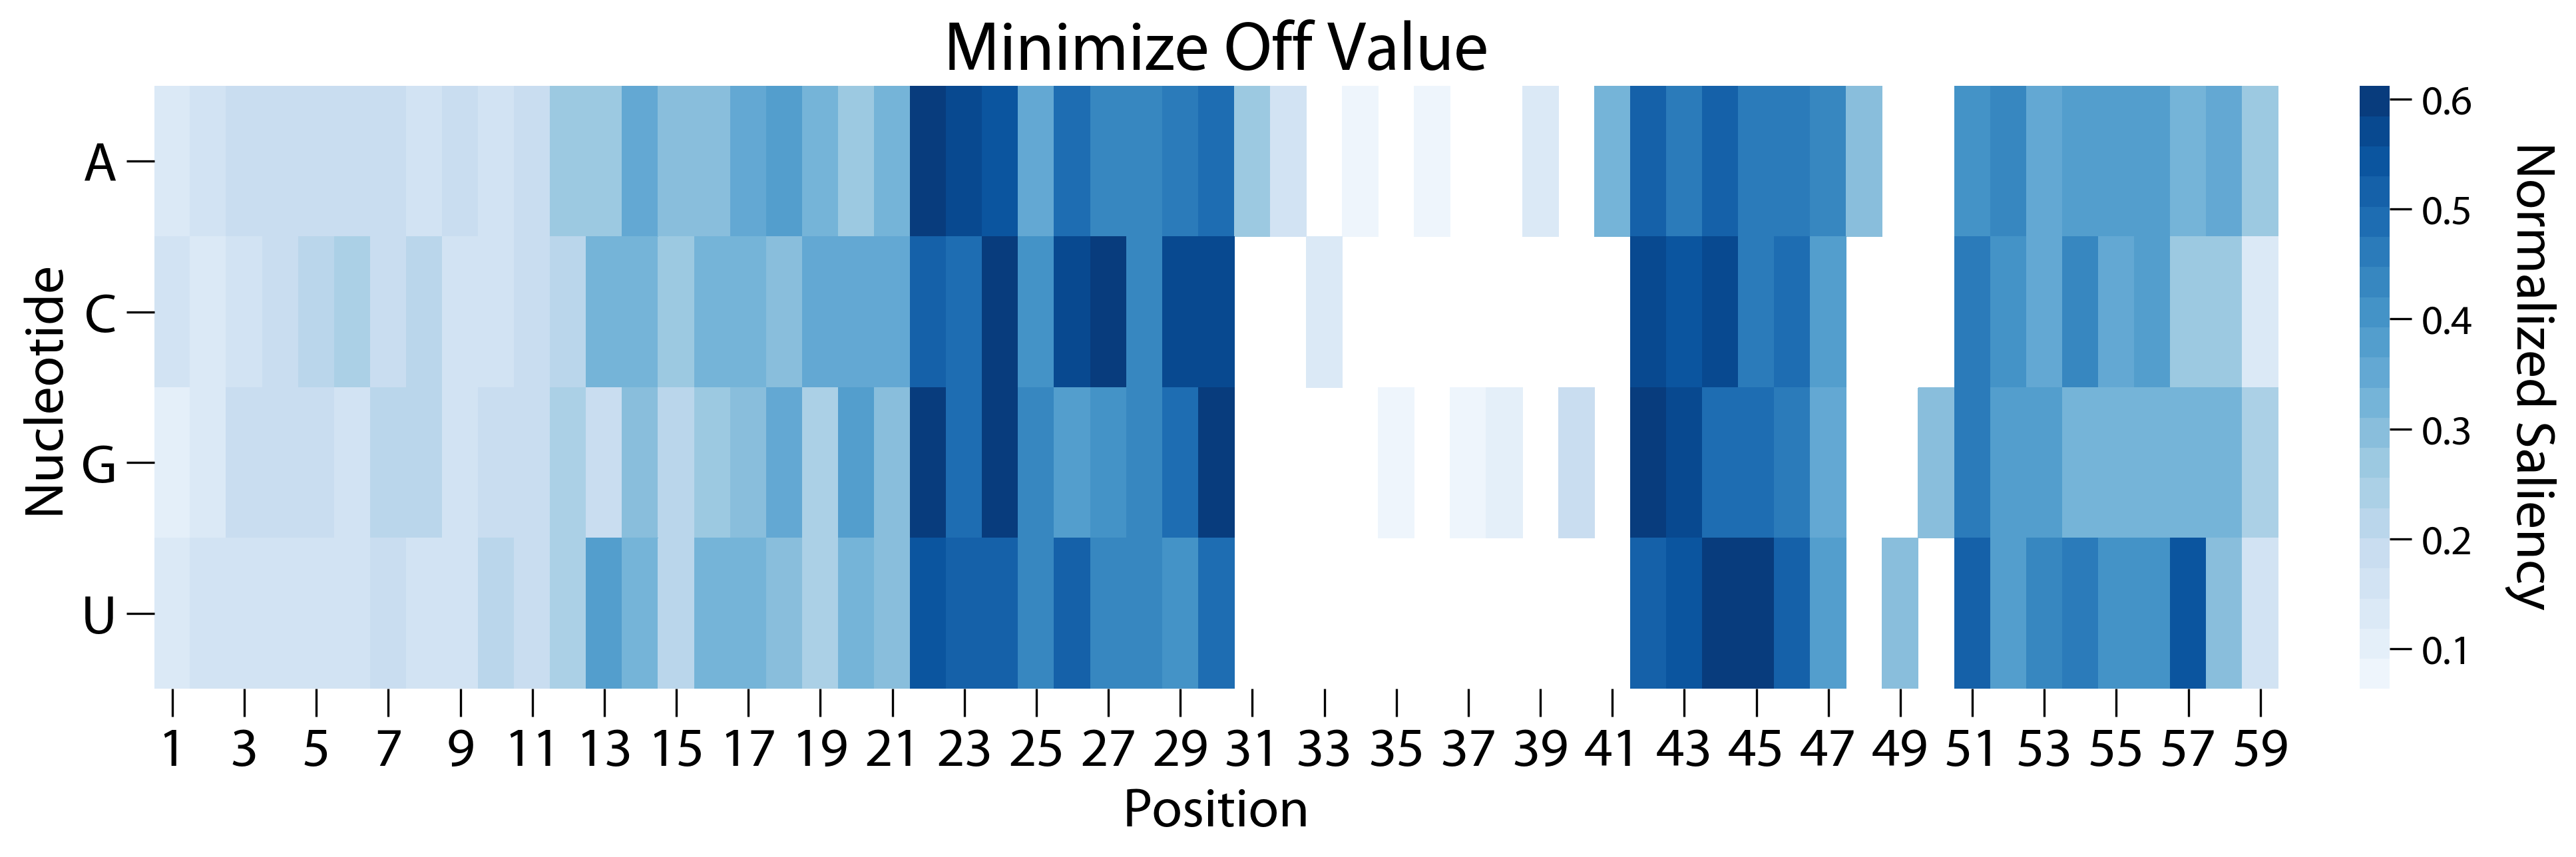

In [13]:
# Normalized by number of times a nt appeared at each position 
fig, ax = plt.subplots(figsize = (15,4), dpi = 300)
plt.rcParams["figure.dpi"] = 300

cmap = sns.color_palette("Blues", n_colors = 20)

g = sns.heatmap([grads_over_letters_off[letter]/counts_per_positon_off[letter] for letter in alph], 
                cmap=cmap,  cbar_kws={"orientation": "vertical", "pad": 0.035, "fraction": 0.05})

ax.tick_params(length = 10)
plt.xticks(np.arange(0.5, 60, 2), np.arange(1, 61, 2), fontsize = 15, rotation = 0)

rna_alph = ['A', 'C', 'G', 'U']
g.set_yticklabels(rna_alph, rotation = 0, **axis_font, fontsize = 20)
g.set_xticklabels(g.get_xticklabels(), **axis_font, fontsize = 20)
plt.xlabel('Position', **axis_font, fontsize = 20)
plt.ylabel('Nucleotide', **axis_font, fontsize = 20)

cbar = ax.collections[0].colorbar
cbar.set_label("Normalized Saliency  ", rotation = 270, **axis_font, fontsize = 20)
ax.collections[0].colorbar.ax.set_yticklabels(ax.collections[0].colorbar.ax.get_yticklabels(), **axis_font)
cbar.ax.get_yaxis().labelpad = 30
cbar_ax = fig.axes[-1]
cbar_ax.tick_params(length = 8, labelsize=15)

plt.title('Minimize Off Value', **axis_font, fontsize = 25)